In [1]:
from src.mtal.data_collect import (
    get_pair_df,
    get_spot_pairs,
    get_stock_data,
    get_ticker_names,
)



df = get_pair_df(
            pair="TRXUSDT",
            limit=200,
            frequency="1d",
            start_time="01/08/24",
        )
df

Open Time,Open,High,Low,Close,Volume,Close Time
datetime[ms],f64,f64,f64,f64,f64,datetime[ms]
2024-08-01 00:00:00,0.1287,0.1298,0.127,0.1283,2.7909e8,2024-08-01 23:59:59.999
2024-08-02 00:00:00,0.1283,0.1284,0.1229,0.1236,3.2254e8,2024-08-02 23:59:59.999
2024-08-03 00:00:00,0.1236,0.1255,0.1229,0.1255,2.8083e8,2024-08-03 23:59:59.999
2024-08-04 00:00:00,0.1255,0.1287,0.125,0.1264,3.9612e8,2024-08-04 23:59:59.999
2024-08-05 00:00:00,0.1264,0.1266,0.117,0.1215,1.1088e9,2024-08-05 23:59:59.999
…,…,…,…,…,…,…
2024-11-15 00:00:00,0.1764,0.1914,0.1761,0.1912,7.5138e8,2024-11-15 23:59:59.999
2024-11-16 00:00:00,0.1912,0.2047,0.1885,0.2002,7.0825e8,2024-11-16 23:59:59.999
2024-11-17 00:00:00,0.2001,0.2013,0.1924,0.1993,5.0002e8,2024-11-17 23:59:59.999


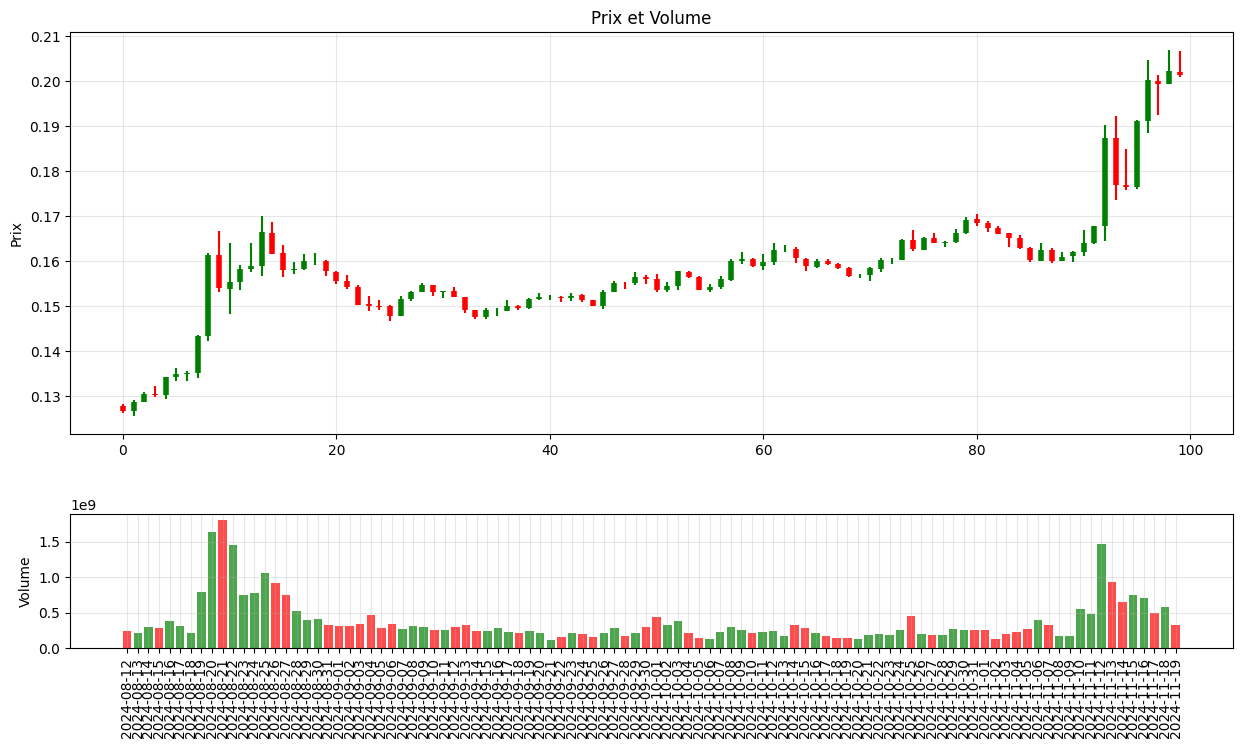

In [2]:
from src.mtal.dataviz import plot_price_history

plot_price_history(df)


In [5]:
import polars as pl
df = df.with_columns(pl.Series(name="idx", values=range(len(df))))

In [25]:
df = df[:-9]

In [26]:
from src.mtal.froment.tasse_hanse import detect_tasse_hanse
import polars as pl

TOLERANCE_THRESHOLD = 0.01

def detect_tasse_hanse(df: pl.DataFrame):
    df = df.with_columns([
        pl.col("Close").rolling_max(window_size=10).alias("local_high")
    ])
    
    potential_setups = []
    top_levels = df["local_high"].unique().sort(descending=True).head(10)[1:]
    
    for resistance_level in top_levels:
        tolerance = resistance_level * TOLERANCE_THRESHOLD
        
        potential_touches = df.filter(
            ((pl.col("Close") >= resistance_level - tolerance) &
            (pl.col("Close") <= resistance_level + tolerance)) |
            ((pl.col("High") >= resistance_level - tolerance) &
            (pl.col("High") <= resistance_level + tolerance))
        ).select("Close Time", "Close", "Volume")
        




        touches = []
        last_touch_idx = None
        BARS_BETWEEN_TOUCHES = 3  # Nombre de barres minimum entre chaque touche

        for i, row in enumerate(potential_touches.iter_rows(named=True)):
            if last_touch_idx is None or (i - last_touch_idx) > BARS_BETWEEN_TOUCHES:
                touches.append(row)
                last_touch_idx = i

        touches = pl.DataFrame(touches)

        if len(touches) < 2:
            continue
            
        first_touch_idx = df.filter(pl.col("Close Time") == touches[0, "Close Time"])["idx"].item()
        first_touch_price = touches[0, "Close"]

        # Calculer la moyenne des prix avant le premier touch
        pre_touch_avg = df.filter(
            pl.col("idx") < first_touch_idx
        )["Close"].mean()

        # Vérifier que la moyenne précédente est inférieure au premier touch
        if pre_touch_avg >= first_touch_price:
            continue

        # Point pivot (fin de la tasse)
        pivot_idx = df.filter(
            pl.col("Close") == resistance_level
        )[0, "Close Time"]
        
        # Données de la tasse (avant le pivot)
        cup_data = df.filter(
            (pl.col("Close Time") >= touches[0, "Close Time"]) &
            (pl.col("Close Time") <= pivot_idx)
        )
        max_cup_distance = abs(resistance_level - cup_data["Close"].min())
        
        # Données de la hanse (après le pivot)
        handle_data = df.filter(pl.col("Close Time") > pivot_idx)
        if len(handle_data) == 0:
            continue
            
        # Vérifier qu'il n'y a pas de points au-dessus dans la tasse
        if cup_data.filter(pl.col("High") > resistance_level + tolerance).height > 0:
            continue

        breakout_point = handle_data.filter(
            pl.col("High") > resistance_level + tolerance
        )[0]
        
            
        handle_distance = abs(resistance_level - handle_data["Close"].min())
        
        # Vérifier que la distance max de la tasse est plus grande que celle de la hanse
        if max_cup_distance <= handle_distance:
            continue
            
        # Vérifier le volume au breakout
        avg_volume = df["Volume"].mean()
        
        first_touch_idx = df.filter(pl.col("Close Time") == touches[0, "Close Time"])["idx"].item()
        pivot_bar_idx = df.filter(pl.col("Close Time") == pivot_idx)["idx"].item()


        tasse_length = pivot_bar_idx - first_touch_idx
        if len(breakout_point) > 0:
            breakout_bar_idx = df.filter(pl.col("Close Time") == breakout_point[0, "Close Time"])["idx"].item()
            hanse_length = breakout_bar_idx - pivot_bar_idx
            breakout_volume_ratio = breakout_point[0, "Volume"] / avg_volume
            end = breakout_bar_idx
        else:
            breakout_bar_idx = None
            hanse_length = df[-1, "idx"] - pivot_bar_idx
            breakout_volume_ratio = 0
            end = df[-1, "idx"]
        if tasse_length > hanse_length and hanse_length > 2:
            potential_setups.append({
                'resistance_level': resistance_level,
                'setup_size': tasse_length + hanse_length,
                'touches': len(touches),
                'breakout_volume_ratio': breakout_volume_ratio,
                'pivot': pivot_bar_idx,
                'begin': first_touch_idx,
                'end': end 
            })
    
    if not potential_setups:
        return False

    for setup in potential_setups:
        print(setup)

    best_setup = max(potential_setups, key=lambda x: x['setup_size'])
    return best_setup

best_setup = detect_tasse_hanse(df)
if best_setup:
    plot_price_history(df, price=best_setup['resistance_level'], start_idx=best_setup['begin'], end_idx=best_setup['end'], limit=len(df))
